In [13]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import polars as pl
import seaborn as sns
from IPython.display import display
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss

https://www.statistik.at/fileadmin/shared/QM/Standarddokumentationen/U/std_u_itgs.pdf

In [14]:
# Load data from ../data/Kaffee_Tee_Mate_und_Gewuerze_2021-2025.csv
df_raw = pl.read_csv("../data/Kaffee_Tee_Mate_und_Gewuerze_2007-2025.csv", separator=";")

# Rename to English
df = df_raw.rename(
    {
        "Zeit": "period",
        "Einfuhr Menge in kg": "import_qty_kg",
        "Ausfuhr Menge in kg": "export_qty_kg",
        "Ausfuhr Wert in Euro": "export_value_eur",
        "Einfuhr Wert in Euro": "import_value_eur",
    }
)

# Convert German month strings like "Jan.21", "Mai.21" into an actual date (YYYY-MM-01)
month_map = {
    "Jan": "01",
    "Feb": "02",
    "Mar": "03",
    "Apr": "04",
    "Mai": "05",
    "Jun": "06",
    "Jul": "07",
    "Aug": "08",
    "Sep": "09",
    "Okt": "10",
    "Nov": "11",
    "Dez": "12",
}

period_clean = pl.col("period").str.strip_chars().str.replace(".", "", literal=True)
month_num = period_clean.str.slice(0, 3).str.replace_many(month_map)
year_2 = period_clean.str.slice(3, 2)

df = df.with_columns(
    pl.format("20{}-{}-01", year_2, month_num)
    .str.to_date("%Y-%m-%d")
    .alias("date")
).drop("period")

df

import_value_eur,export_value_eur,import_qty_kg,export_qty_kg,date
i64,i64,i64,i64,date
27832809,16896986,9857615,4582769,2007-01-01
24173222,13690849,9148603,3889454,2007-02-01
27640476,19932106,10072434,5472440,2007-03-01
25348582,16598993,9156889,4383299,2007-04-01
28266053,16412072,10886785,4189638,2007-05-01
…,…,…,…,…
60794016,20478482,6709337,1897283,2025-05-01
66174649,19961474,7237690,1868009,2025-06-01
65539634,22865544,6930871,2154189,2025-07-01


In [15]:
# Plot helper
def plot_timeseries(df: pl.DataFrame, value_cols: list[str], title: str):
    df_plot = df.sort("date").select(["date", *value_cols])
    df_long = df_plot.unpivot(
        index="date",
        on=value_cols,
        variable_name="series",
        value_name="value",
    )
    fig = px.line(
        df_long.to_pandas(),
        x="date",
        y="value",
        color="series",
        title=title,
    )
    fig.show()
    return fig

Inflation correction with data from wko. 
https://www.wko.at/statistik/prognose/inflation.pdf

In [16]:
# Inflation-adjust the EUR value columns (convert to real 2025 EUR) and plot
inflation = {
    2007: 0.022,
    2008: 0.032,
    2009: 0.005,
    2010: 0.019,
    2011: 0.033,
    2012: 0.024,
    2013: 0.020,
    2014: 0.017,
    2015: 0.009,
    2016: 0.009,
    2017: 0.021,
    2018: 0.020,
    2019: 0.015,
    2020: 0.014,
    2021: 0.028,
    2022: 0.086,
    2023: 0.078,
    2024: 0.029,
    2025: 0.035,
}

# Build a simple CPI index with 2020 = 1.0 (so 2021 includes 2021 inflation, etc.)
cpi = {}
cpi_prev = 1.0
for year in sorted(inflation):
    cpi_prev *= 1 + inflation[year]
    cpi[year] = cpi_prev

cpi_2025 = cpi[2025]
cpi_df = pl.DataFrame({"year": list(cpi.keys()), "cpi": list(cpi.values())})

df = (
    df.with_columns(pl.col("date").dt.year().alias("year"))
    .join(cpi_df, on="year", how="left")
    .with_columns(
        (pl.col("export_value_eur") * (cpi_2025 / pl.col("cpi"))).alias(
            "export_value_eur_real_2025"
        ),
        (pl.col("import_value_eur") * (cpi_2025 / pl.col("cpi"))).alias(
            "import_value_eur_real_2025"
        ),
    )
    .drop(["year", "cpi"])
)

# 1) Your original four-series view, but with inflation-adjusted EUR values
value_cols_real = [
    "import_qty_kg",
    "export_qty_kg",
    "export_value_eur_real_2025",
    "import_value_eur_real_2025",
]
fig_real = plot_timeseries(
    df,
    value_cols=value_cols_real,
    title="Import/Export: quantities + inflation-adjusted values (real 2025 EUR)",
)

# 2) Comparison: nominal EUR vs real (inflation-adjusted) EUR
value_cols_compare = [
    "export_value_eur",
    "export_value_eur_real_2025",
    "import_value_eur",
    "import_value_eur_real_2025",
]
fig_compare = plot_timeseries(
    df,
    value_cols=value_cols_compare,
    title="Nominal vs real values: EUR vs real 2025 EUR (inflation-adjusted)",
)

df

import_value_eur,export_value_eur,import_qty_kg,export_qty_kg,date,export_value_eur_real_2025,import_value_eur_real_2025
i64,i64,i64,i64,date,f64,f64
27832809,16896986,9857615,4582769,2007-01-01,2.7407e7,4.5145e7
24173222,13690849,9148603,3889454,2007-02-01,2.2207e7,3.9209e7
27640476,19932106,10072434,5472440,2007-03-01,3.2330e7,4.4833e7
25348582,16598993,9156889,4383299,2007-04-01,2.6924e7,4.1115e7
28266053,16412072,10886785,4189638,2007-05-01,2.6620e7,4.5848e7
…,…,…,…,…,…,…
60794016,20478482,6709337,1897283,2025-05-01,2.0478482e7,6.0794016e7
66174649,19961474,7237690,1868009,2025-06-01,1.9961474e7,6.6174649e7
65539634,22865544,6930871,2154189,2025-07-01,2.2865544e7,6.5539634e7


Real 2025 EUR” is just the price level you’re expressing everything in (the base year), not the range of years used to compute inflation


build a CPI-like index by compounding the given annual inflation rates for 2021–2025,
then rescale each nominal value by 
CPI
2025
/
CPI
year
CPI 
2025
​
 /CPI 
year
​
 .
So a value from 2021 is “inflation-adjusted from 2021 → 2025” and is therefore expressed in 2025 euros (same purchasing power as 2025). That’s why the column name ends with _real_2025.

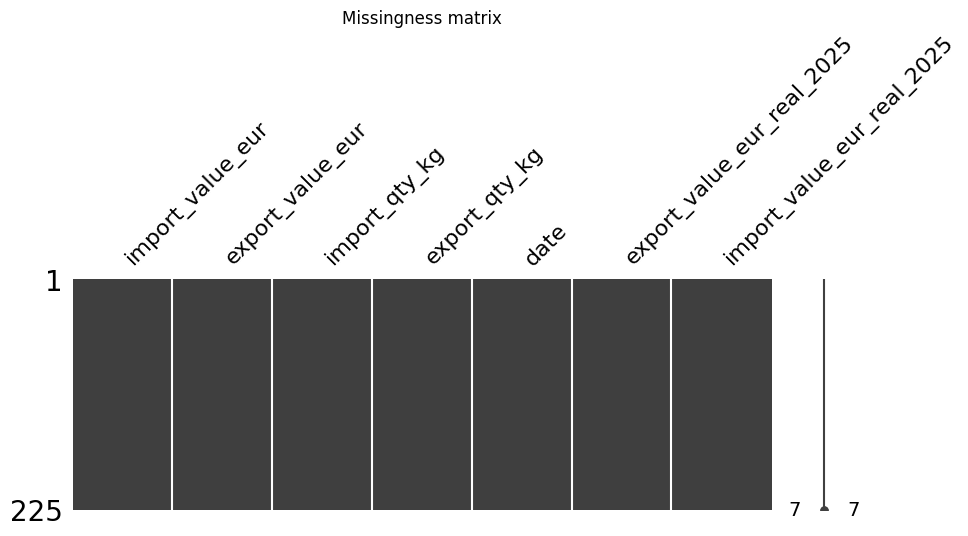

In [17]:
# import missingno as msno
import missingno as msno

pdf = df.to_pandas()

# Visual missingness matrix (rows = observations, cols = variables)
msno.matrix(pdf, figsize=(10, 3))
plt.title("Missingness matrix")
plt.show()

## Time series diagnostics (ADF, KPSS, STL)

This section adds a small “diagnostic stack” to quickly check stationarity and visualize trend/seasonality via STL decomposition.

- **ADF** (Augmented Dickey–Fuller): $H_0$ = unit root (non-stationary)
- **KPSS**: $H_0$ = stationary (level-stationary by default)

A common outcome is:
- ADF **fails** to reject + KPSS **rejects** → likely non-stationary
- ADF **rejects** + KPSS **fails** to reject → likely stationary
- Both reject → may be trend-stationary / structural breaks / other issues
- Both fail → test power is low (short series, noisy series)

,import_qty_kg
date,
2007-01-01,9857615.0
2007-02-01,9148603.0
2007-03-01,10072434.0
2007-04-01,9156889.0
2007-05-01,10886785.0


,series,test,H0,stat,p_value,lags,nobs,crit_1%,crit_5%,crit_10%
0,import_qty_kg,ADF,unit root (non-stationary),-4.155087,0.000784,13,211,-3.461727,-2.875337,-2.574124
1,import_qty_kg,KPSS,stationary (level),0.504143,0.040733,8,225,0.739000,0.463000,0.347000


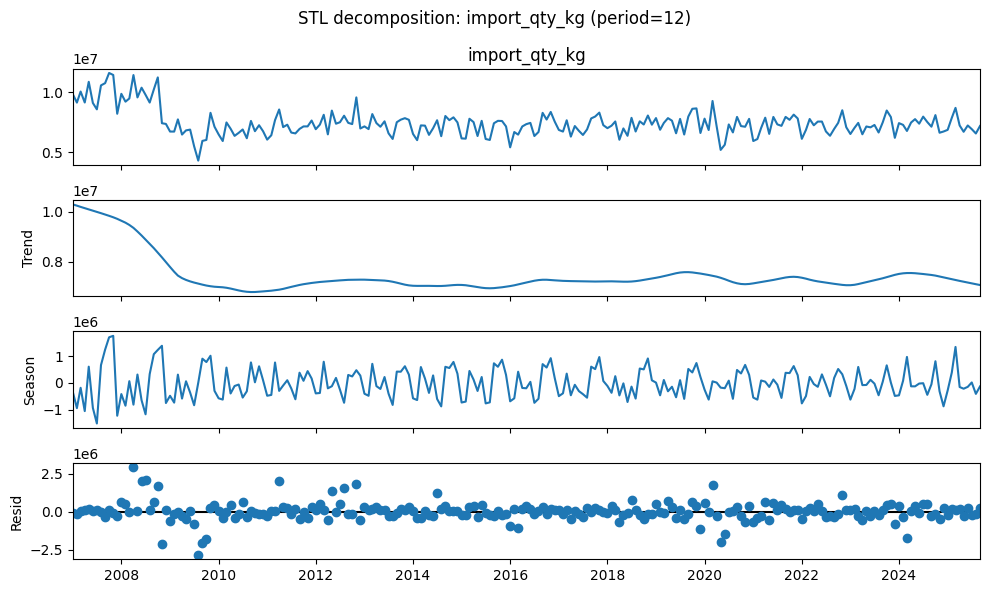

Using series: import_qty_kg


In [18]:
def _as_time_series(
    pdf: pd.DataFrame,
    value_col: str,
    date_col: str = "date",
) -> pd.Series:
    if date_col not in pdf.columns:
        raise KeyError(f"date_col '{date_col}' not found in pdf.columns")
    if value_col not in pdf.columns:
        raise KeyError(f"value_col '{value_col}' not found in pdf.columns")

    ts = (
        pdf[[date_col, value_col]]
        .dropna()
        .assign(**{date_col: pd.to_datetime(pdf[date_col])})
        .sort_values(date_col)
        .set_index(date_col)[value_col]
        .astype(float)
    )
    ts.name = value_col
    return ts


def stationarity_report(ts: pd.Series) -> pd.DataFrame:
    ts = ts.dropna()

    adf_stat, adf_p, adf_lags, adf_nobs, adf_crit, _ = adfuller(ts, autolag="AIC")

    # KPSS commonly emits InterpolationWarning when p-value is outside lookup table.
    # That's not fatal; we suppress it to keep notebook output clean.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", InterpolationWarning)
        kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(
            ts, regression="c", nlags="auto"
        )

    rows = [
        {
            "test": "ADF",
            "H0": "unit root (non-stationary)",
            "stat": adf_stat,
            "p_value": adf_p,
            "lags": adf_lags,
            "nobs": adf_nobs,
            "crit_1%": adf_crit.get("1%"),
            "crit_5%": adf_crit.get("5%"),
            "crit_10%": adf_crit.get("10%"),
        },
        {
            "test": "KPSS",
            "H0": "stationary (level)",
            "stat": kpss_stat,
            "p_value": kpss_p,
            "lags": kpss_lags,
            "nobs": len(ts),
            "crit_1%": kpss_crit.get("1%"),
            "crit_5%": kpss_crit.get("5%"),
            "crit_10%": kpss_crit.get("10%"),
        },
    ]

    out = pd.DataFrame(rows)
    out.insert(0, "series", ts.name)
    return out


def stl_decomposition(ts: pd.Series, period: int = 12, robust: bool = True):
    ts = ts.dropna()
    fit = STL(ts, period=period, robust=robust).fit()
    fig = fit.plot()
    fig.set_size_inches(10, 6)
    fig.suptitle(f"STL decomposition: {ts.name} (period={period})")
    plt.tight_layout()
    plt.show()
    return fit


def diagnostic_stack(
    pdf: pd.DataFrame,
    value_col: str,
    date_col: str = "date",
    stl_period: int = 12,
):
    ts = _as_time_series(pdf, value_col=value_col, date_col=date_col)

    display(ts.to_frame().head())
    display(stationarity_report(ts))
    stl_fit = stl_decomposition(ts, period=stl_period, robust=True)

    return ts, stl_fit


# Pick a sensible default series
_numeric_cols = [
    c for c in pdf.columns if c != "date" and pd.api.types.is_numeric_dtype(pdf[c])
]
DEFAULT_SERIES = (
    "import_qty_kg"
    if "import_qty_kg" in pdf.columns
    else (_numeric_cols[0] if _numeric_cols else None)
)

if DEFAULT_SERIES is None:
    raise ValueError("No numeric columns found in pdf for stationarity diagnostics")

ts, stl_fit = diagnostic_stack(
    pdf, value_col=DEFAULT_SERIES, date_col="date", stl_period=12
)
print("Using series:", DEFAULT_SERIES)

,seasonal_mean,seasonal_mean_abs,seasonal_peak_to_peak
date,,,
2007,-15996.507118,1.016488e+06,3.283658e+06
2008,-20035.102641,7.565366e+05,2.568024e+06
2009,-17035.336780,5.325090e+05,1.853422e+06
2010,-44560.295791,3.936569e+05,1.393807e+06
2011,-16610.347955,3.401120e+05,1.377507e+06
2012,15816.092914,3.638257e+05,1.537078e+06
2013,22296.096878,4.311564e+05,1.540027e+06
2014,22432.671867,5.340136e+05,1.665599e+06
2015,6877.406825,5.446002e+05,1.636837e+06


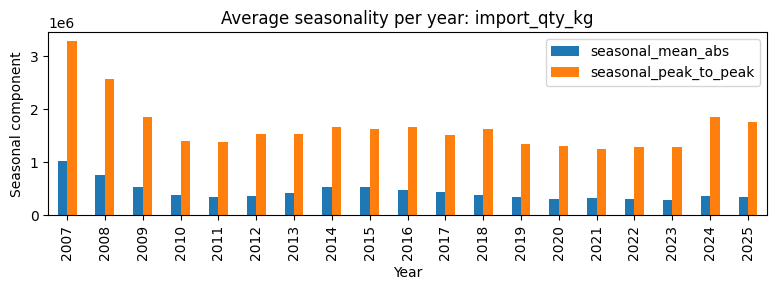

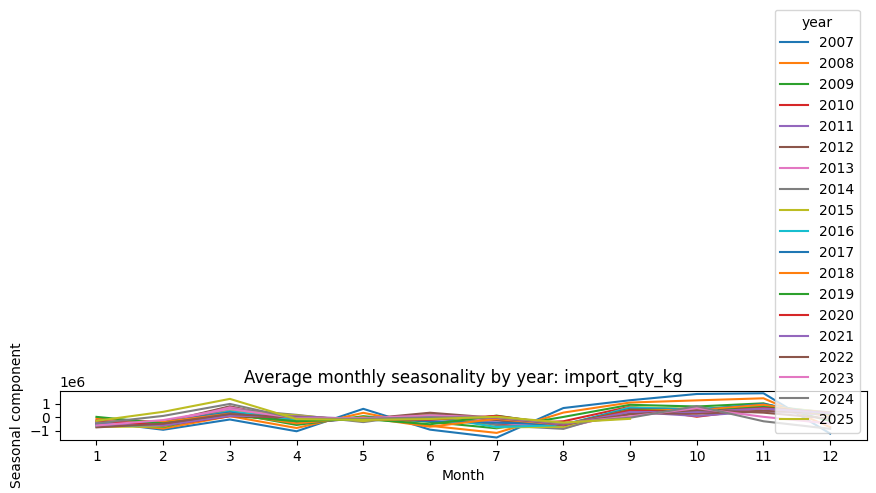

In [19]:
# Avg seasonality per year (from STL seasonal component)
seasonal = stl_fit.seasonal.dropna()

seasonal_by_year = pd.DataFrame(
    {
        "seasonal_mean": seasonal.groupby(seasonal.index.year).mean(),
        "seasonal_mean_abs": seasonal.groupby(seasonal.index.year).apply(lambda s: s.abs().mean()),
        "seasonal_peak_to_peak": seasonal.groupby(seasonal.index.year).apply(lambda s: s.max() - s.min()),
    }
)

display(seasonal_by_year)

ax = seasonal_by_year[["seasonal_mean_abs", "seasonal_peak_to_peak"]].plot(kind="bar", figsize=(8, 3))
ax.set_title(f"Average seasonality per year: {DEFAULT_SERIES}")
ax.set_xlabel("Year")
ax.set_ylabel("Seasonal component")
plt.tight_layout()
plt.show()

# Optional: average seasonal pattern per month (separate line per year)
seasonal_monthly = (
    seasonal.to_frame("seasonal")
    .assign(year=seasonal.index.year, month=seasonal.index.month)
    .groupby(["year", "month"], as_index=False)["seasonal"].mean()
    .pivot(index="month", columns="year", values="seasonal")
)

ax = seasonal_monthly.plot(figsize=(9, 3))
ax.set_title(f"Average monthly seasonality by year: {DEFAULT_SERIES}")
ax.set_xlabel("Month")
ax.set_ylabel("Seasonal component")
ax.set_xticks(range(1, 13))
plt.tight_layout()
plt.show()

In [20]:
# save dataframe to csv
df.write_csv("../data/Kaffee_Tee_Mate_und_Gewuerze_2021-2025_cleaned.csv")

## Autocorrelation (ACF / PACF)

ACF/PACF help diagnose persistence, seasonality (e.g. 12-month effects), and whether differencing might be needed.

Below we plot ACF/PACF for:
- the **raw** series
- the **1st difference** (often closer to stationary)

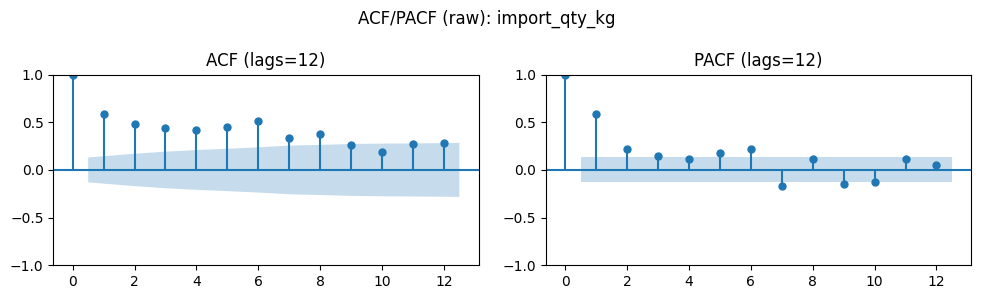

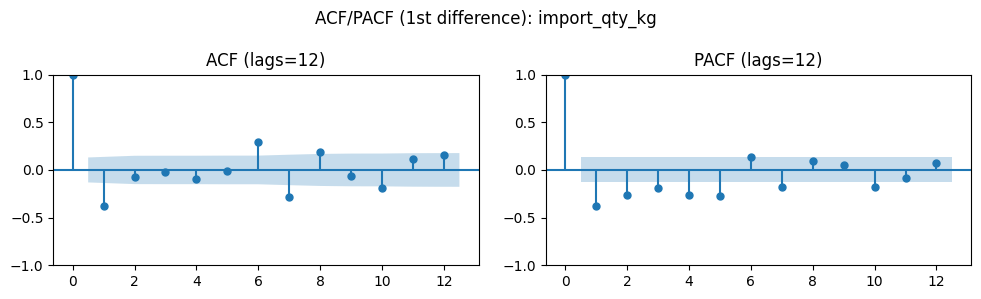

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series: pd.Series, title: str, lags: int = 36):
    s = series.dropna().astype(float)
    n = len(s)
    if n < 5:
        raise ValueError(f"Not enough data for ACF/PACF (n={n}).")

    acf_lags = min(lags, n - 1)
    # statsmodels PACF constraint: nlags must be < 50% of sample size
    pacf_lags = min(lags, max(1, (n // 2) - 1))

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    plot_acf(s, lags=acf_lags, ax=axes[0])
    plot_pacf(s, lags=pacf_lags, ax=axes[1], method="ywm")

    axes[0].set_title(f"ACF (lags={acf_lags})")
    axes[1].set_title(f"PACF (lags={pacf_lags})")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


# Raw series
plot_acf_pacf(ts, title=f"ACF/PACF (raw): {DEFAULT_SERIES}", lags=12)

# 1st difference (often useful if ADF/KPSS suggest non-stationarity)
plot_acf_pacf(ts.diff(1), title=f"ACF/PACF (1st difference): {DEFAULT_SERIES}", lags=12)

## Autocorrelation (not just bars)

These views show autocorrelation in the *data space*:
- **Lag scatterplots**: $y_t$ vs $y_{t-k}$ (good for seeing linear/nonlinear dependence)
- **Rolling autocorrelation**: how correlation at a chosen lag changes over time

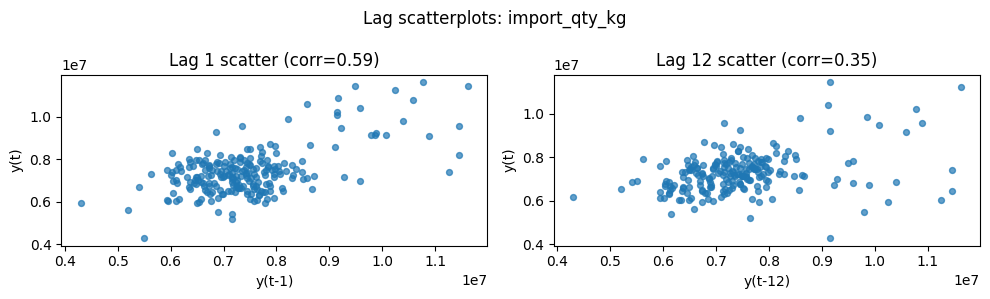

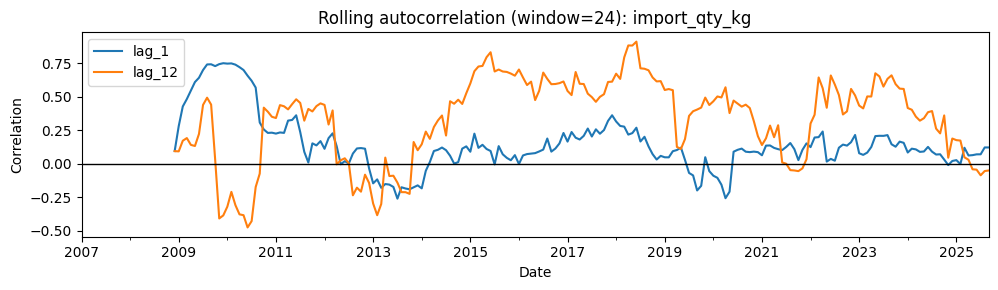

In [24]:
def lag_scatter(series: pd.Series, lag: int, ax=None):
    s = series.dropna().astype(float)
    x = s.shift(lag)
    y = s
    df_xy = pd.DataFrame({"x": x, "y": y}).dropna()

    if ax is None:
        ax = plt.gca()

    ax.scatter(df_xy["x"], df_xy["y"], s=18, alpha=0.7)

    # quick reference line using correlation
    corr = df_xy["x"].corr(df_xy["y"])
    ax.set_title(f"Lag {lag} scatter (corr={corr:.2f})")
    ax.set_xlabel(f"y(t-{lag})")
    ax.set_ylabel("y(t)")


def rolling_autocorr(series: pd.Series, lag: int, window: int):
    s = series.dropna().astype(float)

    # corr between windowed y(t) and y(t-lag)
    def _corr(win: pd.Series) -> float:
        return win.corr(win.shift(lag))

    return s.rolling(window=window).apply(_corr, raw=False)


# 1) Lag scatterplots
lags_to_show = [1, 12]  # add 24 if you want multi-year seasonality

fig, axes = plt.subplots(1, len(lags_to_show), figsize=(10, 3))
if len(lags_to_show) == 1:
    axes = [axes]

for ax, lag in zip(axes, lags_to_show):
    lag_scatter(ts, lag=lag, ax=ax)

fig.suptitle(f"Lag scatterplots: {DEFAULT_SERIES}")
plt.tight_layout()
plt.show()


# 2) Rolling autocorrelation over time
# With monthly data, a 24-month window is a reasonable default.
window = 24
roll_lag1 = rolling_autocorr(ts, lag=1, window=window)
roll_lag12 = rolling_autocorr(ts, lag=12, window=window)

ax = pd.DataFrame({"lag_1": roll_lag1, "lag_12": roll_lag12}).plot(figsize=(10, 3))
ax.set_title(f"Rolling autocorrelation (window={window}): {DEFAULT_SERIES}")
ax.set_xlabel("Date")
ax.set_ylabel("Correlation")
ax.axhline(0.0, color="black", linewidth=1)
plt.tight_layout()
plt.show()